<a href="https://colab.research.google.com/github/mohammed-lafi1035/DS230_final_Project_AE/blob/main/notebookd5beba4ea4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

abdulkareemshayeb_file_dataset_path = kagglehub.dataset_download('abdulkareemshayeb/file-dataset')

print('Data source import complete.')


# **Required libraries.**

In [ ]:
import pandas as pd   #(data frame)هي المكتبة الأساسية الي رح تتعامل مع الجداول
import numpy as np # تُستخدم للعمليات الحسابية والرياضية الموجودة بالمصفوفات
import os # تُستخدم للتعامل مع نظام التشغيل
import gc #  وظيفتها الأساسية هي تفريغ الذاكرة لانه البيانات كبيرة الحجم(RAM) يدوياً من البيانات التي لم تعد بحاجة إليها
import matplotlib.pyplot as plt # هي المكتبة الأم للرسم البياني في بايثون.
import seaborn as sns


### **نستدعي جميع المكتبات المطلوبة للتمكن من اتمام جميع المهام**

# **Reading CSV files.**

In [ ]:
orders=pd.read_csv('/kaggle/input/file-dataset/orders.csv')
products=pd.read_csv('/kaggle/input/file-dataset/products.csv')
departments=pd.read_csv('/kaggle/input/file-dataset/departments.csv')
aisles=pd.read_csv('/kaggle/input/file-dataset/aisles.csv')
prior=pd.read_csv('/kaggle/input/file-dataset/order_products__prior.csv')
train=pd.read_csv('/kaggle/input/file-dataset/order_products__train.csv')



### **(CSV)قراءة جميع المفات بصيغة**

# **Reduce the memory size for all files.**

In [ ]:
def reduce_mem_usage_simple(df):

    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:

            if str(col_type) in ['category', 'datetime64[ns]']:
                continue

            c_min = df[col].min()
            c_max = df[col].max()
#(int 8)او (int 16) و(int 32) الي (int 64) هسه هون الكود رح يمر على جميع الاعمدة و بتحقق من جميع القيم و يحول الارقام من
            if 'int' in str(col_type):

                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)


            elif 'float' in str(col_type):
                df[col] = df[col].astype(np.float16)

        else:

            if len(df[col].unique()) / len(df) < 0.5:
                df[col] = df[col].astype('category')


    return df

orders = reduce_mem_usage_simple(orders)
products = reduce_mem_usage_simple(products)
departments = reduce_mem_usage_simple(departments)
aisles = reduce_mem_usage_simple(aisles)
prior = reduce_mem_usage_simple(prior)
train = reduce_mem_usage_simple(train)
print("To ensure the area is reduced to less than int64\n",orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int32   
 1   user_id                 int32   
 2   eval_set                category
 3   order_number            int8    
 4   order_dow               int8    
 5   order_hour_of_day       int8    
 6   days_since_prior_order  float16 
dtypes: category(1), float16(1), int32(2), int8(3)
memory usage: 45.7 MB
To ensure the area is reduced to less than int64
 None


### (RAM)الهدف الرئيسي من الكود هو التقليل المساحة التي تشغلها البيانات في الذاكرة المؤقتة

### "memory-savvy joins"هذه الخطوة ضرورية جداً لتنفيذ الـ

# **Merge files into one file.**

In [ ]:
# (pandas) من مكتبة (pd) استخدمنا
m1 = pd.merge(prior, orders, on="order_id", how="left")
m2 = pd.merge(m1, products, on="product_id", how="left")
m3 = pd.merge(m2, departments, on="department_id", how="left")
instacart_data = pd.merge(m3, aisles, on="aisle_id", how="left")


del m1, m2, m3, prior, products, departments, aisles
gc.collect()

instacart_data = reduce_mem_usage_simple(instacart_data)




In [ ]:
instacart_data["reordered"]

0           1
1           1
2           0
3           1
4           0
           ..
32434484    1
32434485    0
32434486    0
32434487    1
32434488    1
Name: reordered, Length: 32434489, dtype: int8

### تم دمج جميع الملفات بملف واحد بعد تقليل مساحنهم

# **Missing value analysis.**

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)


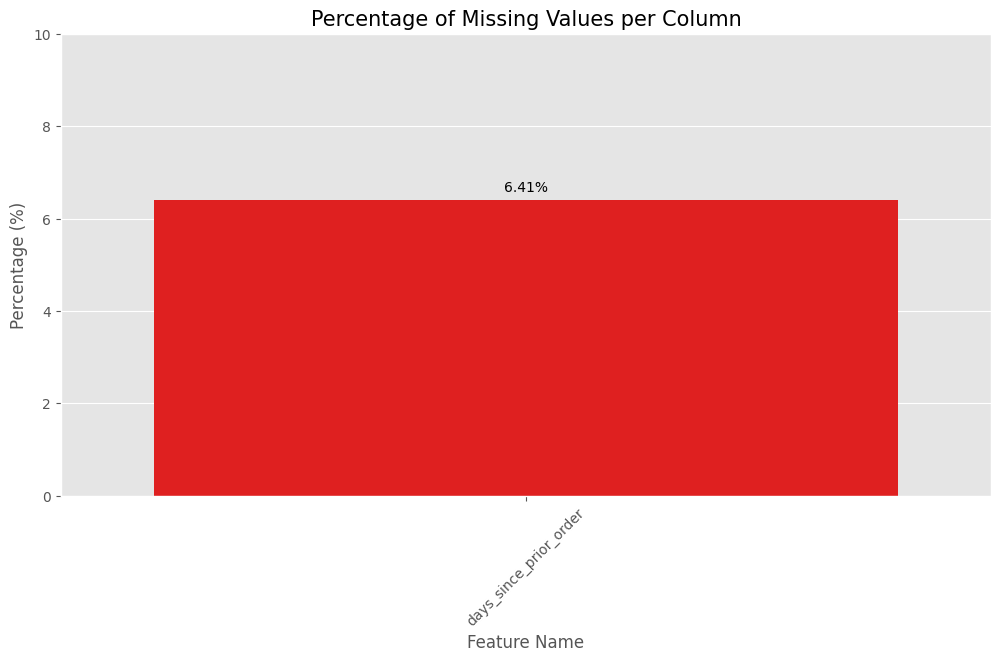

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. حساب عدد ونسبة القيم المفقودة لكل عمود
missing_values = instacart_data.isnull().sum()
missing_percentage = (missing_values / len(instacart_data)) * 100

# 2. تصفية الأعمدة التي تحتوي على قيم مفقودة فقط وترتيبها
missing_df = missing_percentage[missing_percentage > 0].sort_values(ascending=False).reset_index()
missing_df.columns = ['Column', 'Percentage']

# 3. رسم الـ Bar Plot
if not missing_df.empty:
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='Column', y='Percentage', data=missing_df, color="red")

    # إضافة النسب المئوية فوق كل عامود
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 9),
                    textcoords = 'offset points')

    plt.title('Percentage of Missing Values per Column', fontsize=15)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.xlabel('Feature Name', fontsize=12)
    plt.xticks(rotation=45)
    plt.ylim(0, 10) # لتوضيح النسبة من 100
    plt.show()
else:
    print("No missing values found in the dataset! ")

# **Distribution plots for numeric features and target(s).**

## Target A (Classification)

Draw the distribution of the two columns that you will predict later.

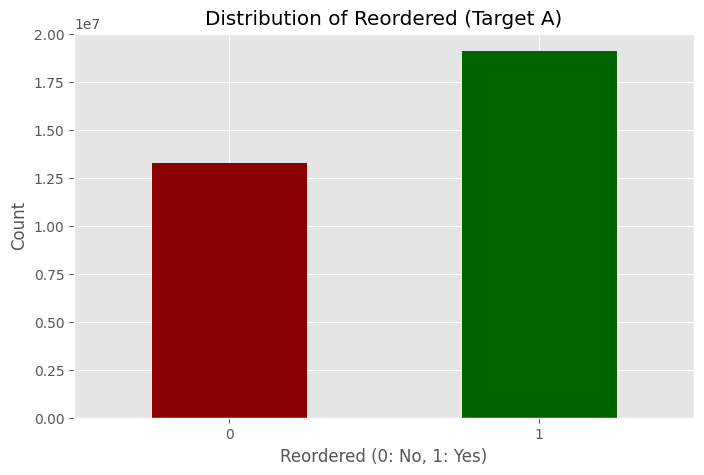

In [ ]:

plt.style.use('ggplot')

# 1. توزيع هدف التصنيف (Classification Target: reordered)

reorder_counts = instacart_data['reordered'].value_counts().sort_index()#لتلخيص ملايين الأسطر في جدول صغير جداً value_counts().sort_index() استخدمنا ال

plt.figure(figsize=(8, 5))
reorder_counts.plot(kind='bar', color=['darkred', 'darkgreen'])#(RAM)للتخفيف الثقل على الذاكرة المؤقتة  kind=barاستخدمنا ال
plt.title('Distribution of Reordered (Target A)')
plt.xlabel('Reordered (0: No, 1: Yes)')#عشان نعرف نسبة الفرق بين الطلبات التي اعيد طلبها و الطلبات التي لم يعاد طلبها
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


## Consumer Behavior

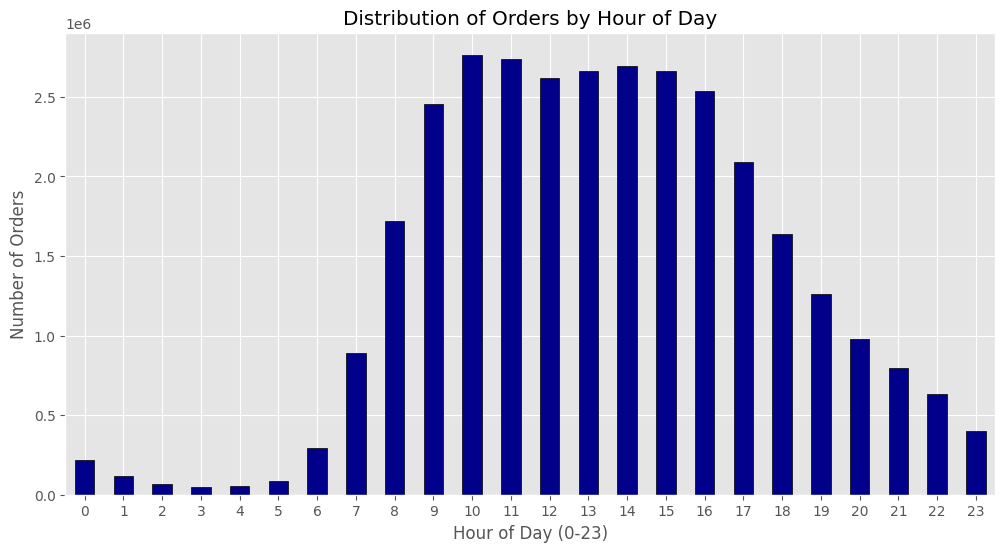

In [ ]:
# 2. توزيع ساعة الطلب
#لنعرف الفترة التي تكون فيها الطلبات كثيرة ( ساعة الذروة) او العكس
hour_counts = instacart_data['order_hour_of_day'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
hour_counts.plot(kind='bar', color='darkblue', edgecolor='black')
plt.title('Distribution of Orders by Hour of Day')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Number of Orders')
plt.xticks(rotation=0)
plt.show()

### بنلاحظ انه الطلبات كثير بتكون بين فترة الساعة العاشرة صباحا الى الساعة الرابعة مساء

## Purchasing volume for all days of the week

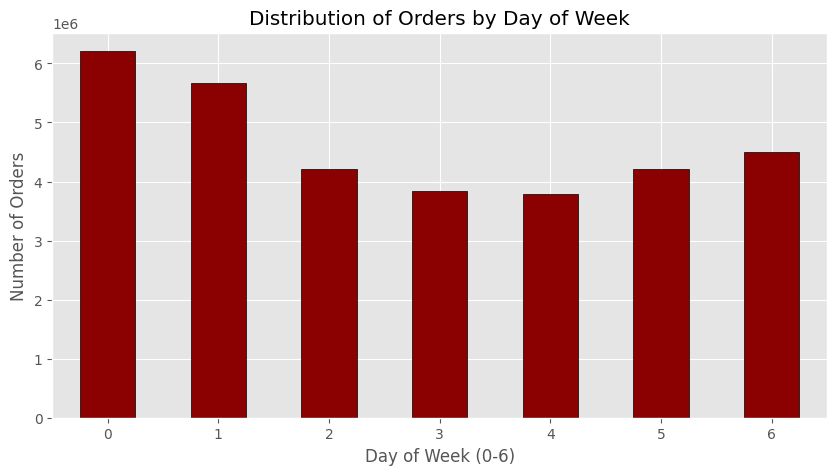

In [ ]:
# 3. توزيع أيام الأسبوع
dow_counts = instacart_data['order_dow'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
dow_counts.plot(kind='bar', color='darkred', edgecolor='black')
plt.title('Distribution of Orders by Day of Week')
plt.xlabel('Day of Week (0-6)')
plt.ylabel('Number of Orders')
plt.xticks(rotation=0)
plt.show()

## Regression Target: (days_since_prior_order)

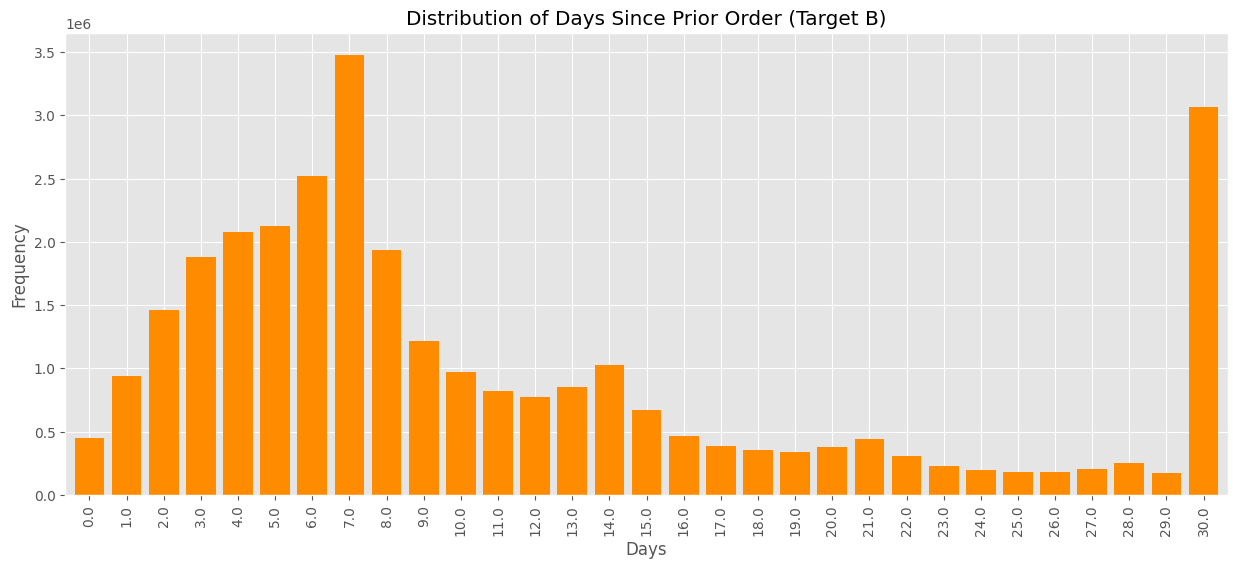

In [ ]:
# 4. توزيع الأيام منذ الطلب السابق (Regression Target: days_since_prior_order)
# ملاحظة: سنقوم بحذف القيم المفقودة مؤقتا للرسم فقط
days_counts = instacart_data['days_since_prior_order'].value_counts().sort_index()

plt.figure(figsize=(15, 6))
days_counts.plot(kind='bar', color='darkorange', width=0.8)
plt.title('Distribution of Days Since Prior Order (Target B)')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.show()

### بنلاحظ بوجود اعلى القمم عند اليوم ال7 واليوم ال30 وهذا الاشي بعني انه الناس يميلون للطلب اسبوعيا و شهريا

# **Categorical cardinality analysis.**

In [ ]:

categorical_cols = instacart_data.select_dtypes(include=['object', 'category']).columns#ب هذا اللاين بعمل على فلترة او اختيار الاعمدة الفئوية
categorical_cols


Index(['eval_set', 'product_name', 'department', 'aisle'], dtype='object')

### الكود حددلنا الاعمدة الي بتحتوي على اعمدة فئوية بالاوت بوت

In [ ]:
cardinality_df = pd.DataFrame({
    'Feature': categorical_cols,
    'Cardinality': [instacart_data[col].nunique() for col in categorical_cols]
}).sort_values(by='Cardinality', ascending=False)


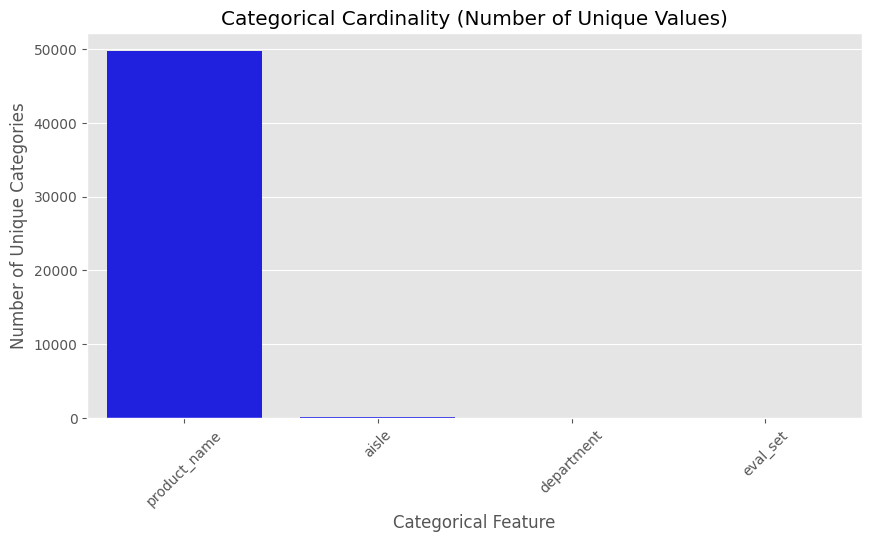

,Feature,Cardinality
1,product_name,49677
3,aisle,134
2,department,21
0,eval_set,1


In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=cardinality_df,
    x='Feature',
    y='Cardinality',
    color='blue'
)

plt.title('Categorical Cardinality (Number of Unique Values)')
plt.xlabel('Categorical Feature')
plt.ylabel('Number of Unique Categories')
plt.xticks(rotation=45)
plt.show()

cardinality_df

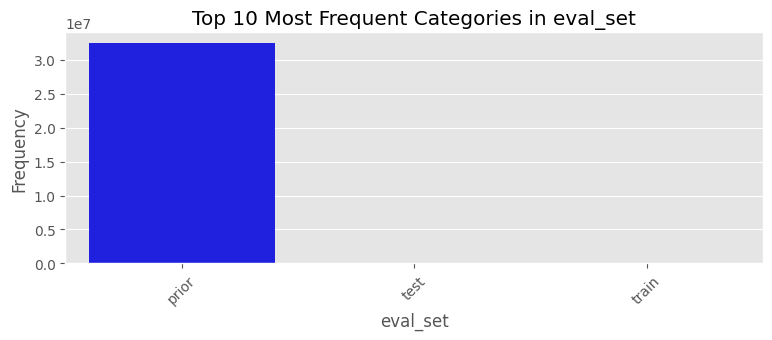

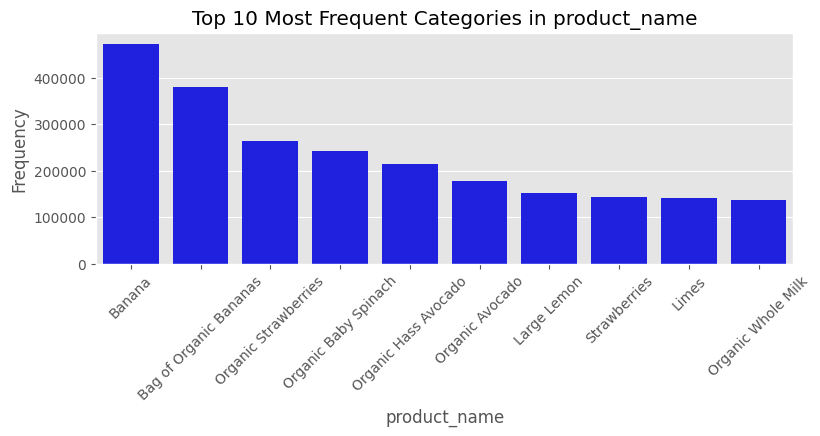

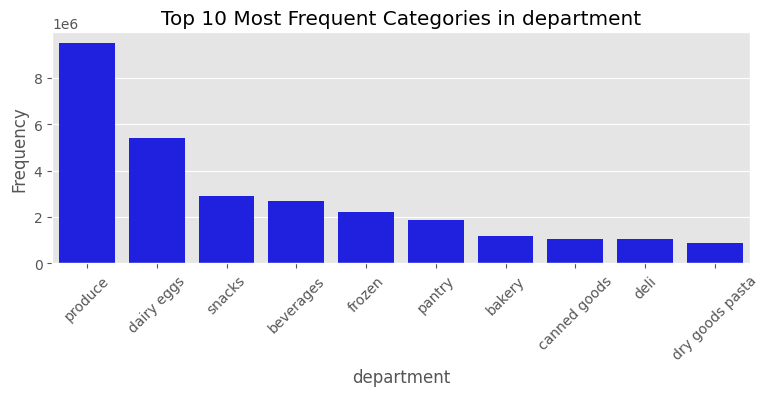

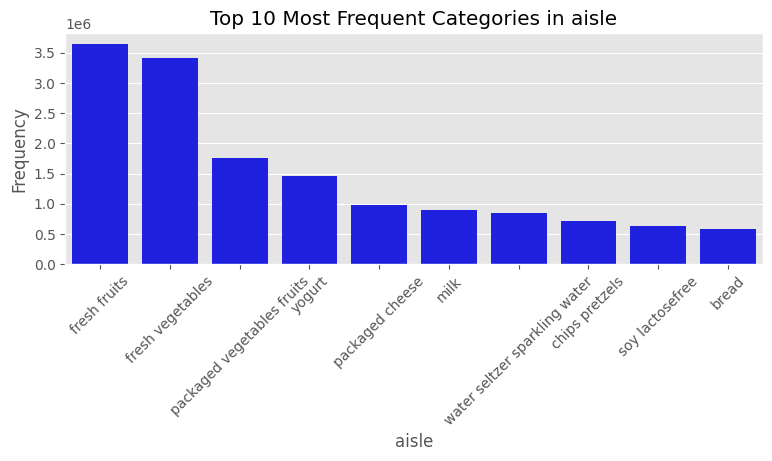

In [ ]:
TOP_K = 10  # عدد القيم الأكثر تكرارًا

for col in categorical_cols:
    top_k = instacart_data[col].value_counts().head(TOP_K)

    plt.figure(figsize=(9, 3))
    sns.barplot(
        x=top_k.index.astype(str),
        y=top_k.values,
        color='blue'
    )

    plt.title(f'Top {TOP_K} Most Frequent Categories in {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()


# **Correlation matrix, heatmap and pairwise scatter plots for selected numeric features.**

## Correlation Heatmap

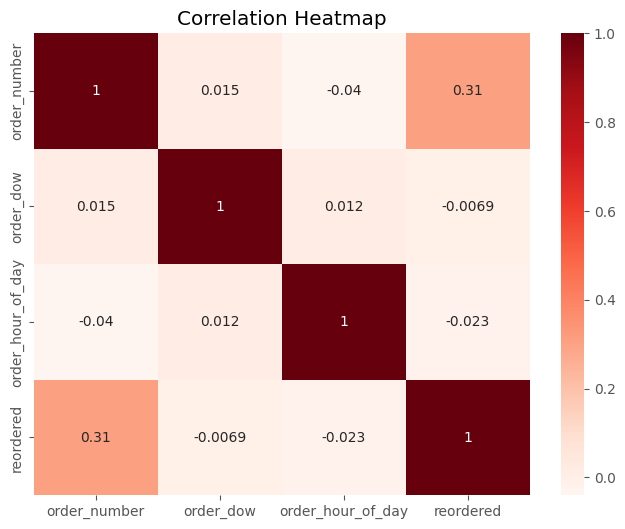

In [ ]:

# اختيار أهم الأعمدة الرقمية
numeric_cols = ['order_number', 'order_dow', 'order_hour_of_day', 'reordered']

# رسم الخريطة الحرارية ببساطة
plt.figure(figsize=(8, 6))
sns.heatmap(instacart_data[numeric_cols].corr(), annot=True, cmap='Reds')
plt.title('Correlation Heatmap')
plt.show()

## Pairwise Scatter Plots

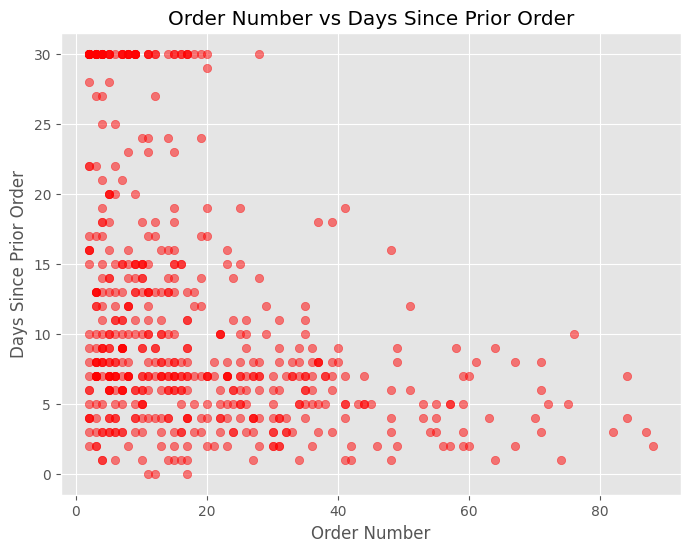

In [ ]:
# أخذ عينة عشوائية بسيطة (600 نقطة)
sample_df = instacart_data.sample(600)

plt.figure(figsize=(8, 6))
plt.scatter(sample_df['order_number'], sample_df['days_since_prior_order'], alpha=0.5, color='red')
plt.title('Order Number vs Days Since Prior Order')
plt.xlabel('Order Number')
plt.ylabel('Days Since Prior Order')
plt.show()

## Target vs Feature

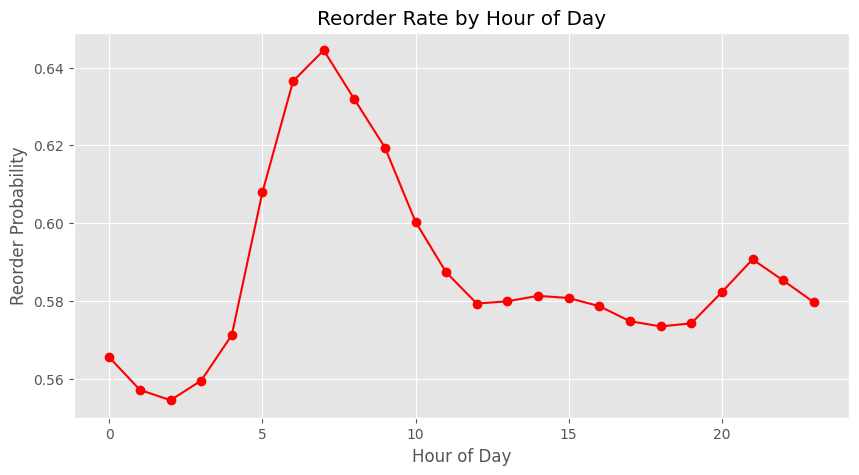

In [ ]:
# حساب متوسط إعادة الطلب لكل ساعة
hourly_trend = instacart_data.groupby('order_hour_of_day')['reordered'].mean()

plt.figure(figsize=(10, 5))
hourly_trend.plot(color='red', marker='o')
plt.title('Reorder Rate by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Reorder Probability')
plt.grid(True)
plt.show()

# **Cleaning & Imputation**

## Define and justify imputation techniques for missing fields(mode)

In [ ]:
# 1. استخدام Sentinel Value لعمود days_since_prior_order
# التبرير: القيمة المفقودة هنا تعني حرفياً "لا يوجد طلب سابق"، لذا الصفر يعبر عن البداية
instacart_data['days_since_prior_order'] = instacart_data['days_since_prior_order'].fillna(0)

# 2. مثال على استخدام Median لعمود عددي (في حال وجود قيم مفقودة أخرى مستقبلاً)
# التبرير: الوسيط يحافظ على توزيع البيانات دون التأثر بالقيم المتطرفة
# instacart_data['some_numeric_column'].fillna(instacart_data['some_numeric_column'].median(), inplace=True)

# 3. مثال على استخدام Mode للأعمدة الفئوية
# التبرير: ملء البيانات بالقيمة الأكثر شيوعاً لضمان منطقية البيانات
# mode_val = instacart_data['aisle'].mode()[0]
# instacart_data['aisle'].fillna(mode_val, inplace=True)

# التأكد من خلو البيانات من القيم المفقودة بعد التنفيذ
print(instacart_data.isnull().sum())

order_id                  0
product_id                0
add_to_cart_order         0
reordered                 0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_name              0
aisle_id                  0
department_id             0
department                0
aisle                     0
dtype: int64


## Outlier detection & treatment

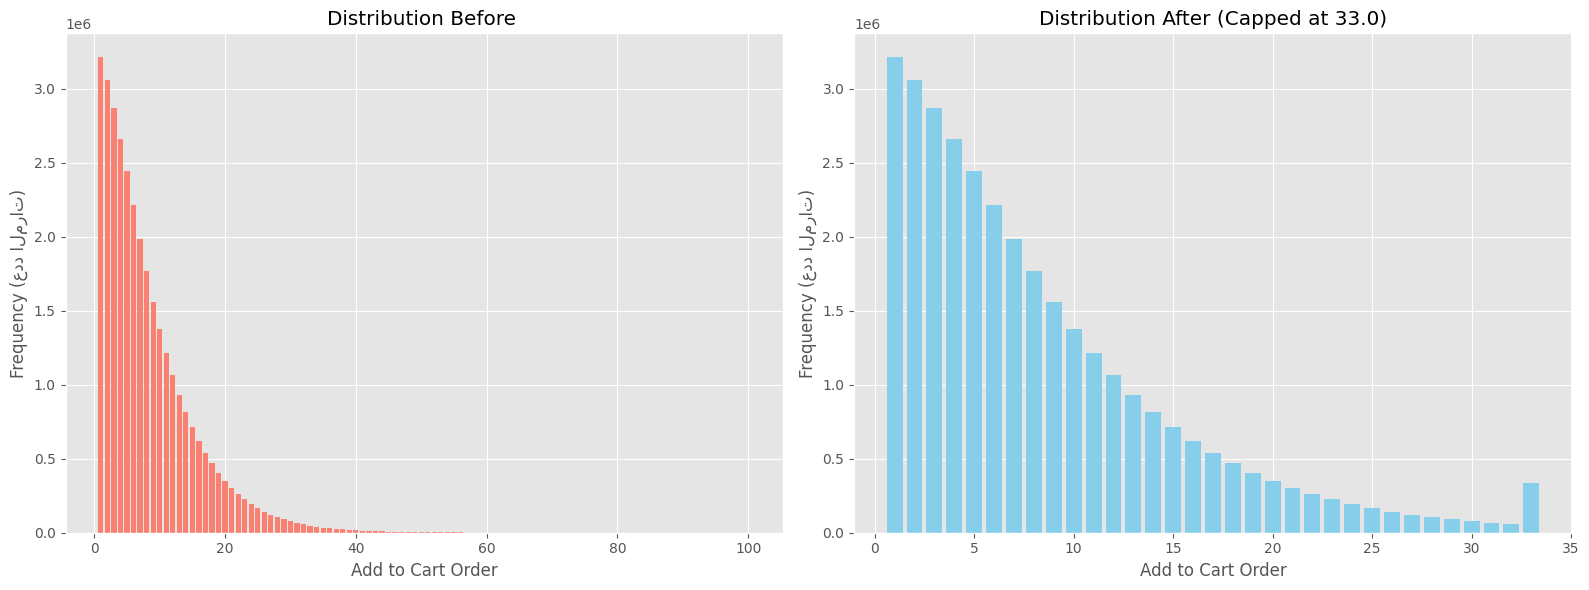

Justification: Values above 33.0 were capped to prevent outliers from skewing the model.


In [ ]:


# 1. تحديد السقف (المئوية 99) لعمود ترتيب إضافة المنتج للسلة
limit = instacart_data['add_to_cart_order'].quantile(0.99)

# 2. تجهيز البيانات للرسم (حساب التكرارات قبل المعالجة)
counts_before = instacart_data['add_to_cart_order'].value_counts().sort_index()

# 3. تطبيق المعالجة (Winsorizing): تثبيت أي قيمة فوق الـ limit لتصبح مساوية له
instacart_data['add_to_cart_order'] = instacart_data['add_to_cart_order'].clip(upper=limit)

# 4. حساب التكرارات بعد المعالجة
counts_after = instacart_data['add_to_cart_order'].value_counts().sort_index()

# 5. رسم الـ Bar Plot للمقارنة
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# الرسمة الأولى: قبل المعالجة (لاحظ الذيل الطويل جداً للبيانات)
ax[0].bar(counts_before.index[:100], counts_before.values[:100], color='salmon') # عرضنا أول 100 قيمة فقط للوضوح
ax[0].set_title('Distribution Before ')
ax[0].set_xlabel('Add to Cart Order')
ax[0].set_ylabel('Frequency (عدد المرات)')

# الرسمة الثانية: بعد المعالجة (لاحظ كيف تجمعت القيم الشاذة عند السقف)
ax[1].bar(counts_after.index, counts_after.values, color='skyblue')
ax[1].set_title(f'Distribution After (Capped at {limit})')
ax[1].set_xlabel('Add to Cart Order')
ax[1].set_ylabel('Frequency (عدد المرات)')

plt.tight_layout()
plt.show()

print(f"Justification: Values above {limit} were capped to prevent outliers from skewing the model.")

# **Feature engineering (mandatory list)**

## User-level features:

In [ ]:


# إعادة قراءة الملفات لضمان وجودها في الذاكرة
orders = pd.read_csv('/kaggle/input/file-dataset/orders.csv')
prior = pd.read_csv('/kaggle/input/file-dataset/order_products__prior.csv')

#الآن نقوم بالدمج وحساب الميزات المطلوبة
user_features_df = pd.merge(prior, orders, on='order_id')

# حساب ميزات المستخدم (Mandatory User-level features)
user_final = user_features_df.groupby('user_id').agg(
   total_orders=('order_number', 'max'),               # إجمالي عدد الطلبات
   reorder_ratio=('reordered', 'mean'),                # نسبة إعادة الطلب
   mean_days_between=('days_since_prior_order', 'mean') # متوسط الأيام بين الطلبات
).reset_index()

# حساب متوسط حجم السلة (Average basket size)
basket_size = user_features_df.groupby(['user_id', 'order_id']).size().reset_index(name='size')
avg_basket = basket_size.groupby('user_id')['size'].mean().reset_index(name='avg_basket_size')

# حساب الحداثة (Last order recency)
last_recency = orders.groupby('user_id')['days_since_prior_order'].last().reset_index(name='last_order_recency')


user_features_final = user_final.merge(avg_basket, on='user_id').merge(last_recency, on='user_id')


print(user_features_final.head())

   user_id  total_orders  reorder_ratio  mean_days_between  avg_basket_size  \
0        1            10       0.694915          20.259259         5.900000   
1        2            14       0.476923          15.967033        13.928571   
2        3            12       0.625000          11.487179         7.333333   
3        4             5       0.055556          15.357143         3.600000   
4        5             4       0.378378          14.500000         9.250000   

   last_order_recency  
0                14.0  
1                30.0  
2                11.0  
3                30.0  
4                 6.0  


## Product-level features:

In [ ]:
products=pd.read_csv('/kaggle/input/file-dataset/products.csv')#رجعنا قرأناها عشان نضمن انه ما راحت من الذاكرة
#  حساب معدل إعادة الشراء الكلي لكل منتج
# وحساب متوسط ترتيبه في السلة

product_stats = prior.groupby('product_id').agg(
    total_product_orders=('order_id', 'count'),          # كم مرة انشرى المنتج
    overall_reorder_rate=('reordered', 'mean'),          # نسبة إعادة الشراء
    avg_pos_in_cart=('add_to_cart_order', 'mean')        # متوسط الترتيب في السلة
).reset_index()

#  حساب شهرة المنتج عبر الزمن
# رح ندمج مع جدول orders عشان نجيب الساعة واليوم
product_temporal = pd.merge(prior[['product_id', 'order_id']],
                            orders[['order_id', 'order_hour_of_day']],
                            on='order_id')

# مثال: أكثر ساعة بكون فيها المنتج مشهور
pop_hour = product_temporal.groupby('product_id')['order_hour_of_day'].agg(lambda x: x.mode()[0]).reset_index(name='peak_hour')

# 3. دمج الميزات مع أسماء المنتجات لسهولة القراءة
product_features_final = pd.merge(product_stats, products[['product_id', 'product_name']], on='product_id')
product_features_final = pd.merge(product_features_final, pop_hour, on='product_id')

# 1. تقريب ميزات المستخدم (User Features)
user_features_final = user_features_final.round(2)

# 2. تقريب ميزات المنتج (Product Features)
product_features_final = product_features_final.round(2)




# عرض البيانات للتأكد من أن الخانات العشرية أصبحت 2 فقط
print("--- ميزات التفاعل بعد التقريب ---")


print(product_features_final.head())#عشان نتأ من انه كلشي صح

--- ميزات التفاعل بعد التقريب ---
   product_id  total_product_orders  overall_reorder_rate  avg_pos_in_cart  \
0           1                  1852                  0.61             5.80   
1           2                    90                  0.13             9.89   
2           3                   277                  0.73             6.42   
3           4                   329                  0.45             9.51   
4           5                    15                  0.60             6.47   

                                        product_name  peak_hour  
0                         Chocolate Sandwich Cookies         10  
1                                   All-Seasons Salt         11  
2               Robust Golden Unsweetened Oolong Tea         11  
3  Smart Ones Classic Favorites Mini Rigatoni Wit...         14  
4                          Green Chile Anytime Sauce         11  


## User×Product interaction features:

In [ ]:


# 1. دمج جدول prior مع orders عشان نجيب الـ user_id
# لازم نعمل هاي الخطوة لأن user_id مش موجود في ملف prior
prior_full = pd.merge(prior, orders[['order_id', 'user_id']], on='order_id')

# 2. الآن نحسب ميزات التفاعل (User-Product Features)
user_product_features = prior_full.groupby(['user_id', 'product_id']).agg(
    user_product_total_orders=('order_id', 'count'),      # كم مرة اشترى المستخدم هذا المنتج
    user_product_avg_add_to_cart_order=('add_to_cart_order', 'mean') # متوسط ترتيبه في السلة
).reset_index()

# 3. حساب احتمالية إعادة الشراء لهذا المستخدم لهذا المنتج
# ندمج مع إجمالي طلبات المستخدم اللي حسبناها سابقاً
user_product_features = pd.merge(user_product_features, user_features_final[['user_id', 'total_orders']], on='user_id')
user_product_features['user_product_reorder_rate'] = user_product_features['user_product_total_orders'] / user_product_features['total_orders']

# 1. تقريب ميزات المستخدم
user_features_final = user_features_final.round(2)

# 2. تقريب ميزات المنتج
product_features_final = product_features_final.round(2)

# 3. تقريب ميزات التفاعل
user_product_features = user_product_features.round(2)

# عرض مثال للتأكد
print(user_product_features.head())


   user_id  product_id  user_product_total_orders  \
0        1         196                         10   
1        1       10258                          9   
2        1       10326                          1   
3        1       12427                         10   
4        1       13032                          3   

   user_product_avg_add_to_cart_order  total_orders  user_product_reorder_rate  
0                                1.40            10                        1.0  
1                                3.33            10                        0.9  
2                                5.00            10                        0.1  
3                                3.30            10                        1.0  
4                                6.33            10                        0.3  


## Temporal features:

In [ ]:
# 1. تعريف المواسم بناءً على الشهر (إذا كان متوفر، وإلا سنعتمد على تحليل السلوك)
# بما أن بيانات إنستاكارت الأصلية تعطي Day of Week و Hour، سنضيف ميزة "نهاية الأسبوع"
orders['is_weekend'] = orders['order_dow'].apply(lambda x: 1 if x in [0, 1] else 0)

# 2. تصنيف فترات اليوم (Morning, Afternoon, Evening, Night)
def get_day_part(hour):
    if 5 <= hour < 12: return 'morning'
    elif 12 <= hour < 17: return 'afternoon'
    elif 17 <= hour < 21: return 'evening'
    else: return 'night'

orders['day_part'] = orders['order_hour_of_day'].apply(get_day_part)

# 3. تحويل فترات اليوم إلى أرقام (Categorical Encoding) ليفهمها الموديل
orders = pd.get_dummies(orders, columns=['day_part'], prefix='part')

# 4. تقريب أي ميزات زمنية ناتجة (إن وجدت كسور)
orders = orders.round(2)


print(orders[['order_id', 'order_dow', 'order_hour_of_day', 'is_weekend']].head())

   order_id  order_dow  order_hour_of_day  is_weekend
0   2539329          2                  8           0
1   2398795          3                  7           0
2    473747          3                 12           0
3   2254736          4                  7           0
4    431534          4                 15           0


## Aggregations over windows

In [ ]:

# [cite_start]1. وظيفة لتقليل استهلاك الذاكرة (Memory Optimization) - متطلب إلزامي [cite: 6, 189]
def reduce_mem(df):
    for col in df.columns:
        if df[col].dtype == 'float64': df[col] = df[col].astype(np.float32)
        if df[col].dtype == 'int64': df[col] = df[col].astype(np.int32)
    return df

# تقليل حجم الجداول الأساسية
prior = reduce_mem(prior)
orders = reduce_mem(orders)

# [cite_start]2. ميزات مستوى المستخدم (User-level features) [cite: 7, 43]
user_features = prior.merge(orders, on='order_id').groupby('user_id').agg(
    total_orders=('order_number', 'max'),
    reorder_ratio=('reordered', 'mean'),
    mean_days_between=('days_since_prior_order', 'mean')
).reset_index()

# [cite_start]ميزة غير خطية: Log Transform لعدد الطلبات (Non-linear feature) [cite: 48]
user_features['log_total_orders'] = np.log1p(user_features['total_orders'])

# [cite_start]3. ميزات مستوى المنتج (Product-level features) [cite: 7, 44]
product_features = prior.groupby('product_id').agg(
    total_product_orders=('order_id', 'count'),
    overall_reorder_rate=('reordered', 'mean'),
    avg_pos_in_cart=('add_to_cart_order', 'mean')
).reset_index()

# [cite_start]4. ميزات التفاعل (User-Product interaction) [cite: 7, 45]
# [cite_start]ندمج فقط الأعمدة الضرورية لتوفير المساحة [cite: 22]
interaction_features = prior.merge(orders[['order_id', 'user_id']], on='order_id').groupby(['user_id', 'product_id']).agg(
    user_product_total_orders=('order_id', 'count')
).reset_index()

# [cite_start]5. ميزات النافذة (Aggregations over last 3 orders)
# حساب حجم السلة لكل طلب
basket_sizes = prior.merge(orders[['order_id', 'user_id', 'order_number']], on='order_id') \
               .groupby(['user_id', 'order_id', 'order_number']).size().reset_index(name='basket_size')
basket_sizes = basket_sizes.sort_values(['user_id', 'order_number'])
basket_sizes['avg_basket_last_3'] = basket_sizes.groupby('user_id')['basket_size'].transform(lambda x: x.rolling(3, min_periods=1).mean())
user_window_final = basket_sizes.groupby('user_id').tail(1)[['user_id', 'avg_basket_last_3']]

# [cite_start]6. الدمج النهائي لكل الميزات (Final Master Table) [cite: 6, 191]
final_df = interaction_features.merge(user_features, on='user_id', how='left') \
                               .merge(product_features, on='product_id', how='left') \
                               .merge(user_window_final, on='user_id', how='left')

# 7. التقريب لخانتين عشريتين [للمساحة والوضوح]
final_df = final_df.round(2)

# تنظيف الذاكرة
del basket_sizes, interaction_features, user_features, product_features
gc.collect()

print("--- الجدول النهائي للميزات جاهز ---")
print(final_df.head())

--- الجدول النهائي للميزات جاهز ---
   user_id  product_id  user_product_total_orders  total_orders  \
0        1         196                         10            10   
1        1       10258                          9            10   
2        1       10326                          1            10   
3        1       12427                         10            10   
4        1       13032                          3            10   

   reorder_ratio  mean_days_between  log_total_orders  total_product_orders  \
0           0.69              20.26               2.4                 35791   
1           0.69              20.26               2.4                  1946   
2           0.69              20.26               2.4                  5526   
3           0.69              20.26               2.4                  6476   
4           0.69              20.26               2.4                  3751   

   overall_reorder_rate  avg_pos_in_cart  avg_basket_last_3  
0                  0.78 

## At least one engineered non-linear feature:

In [ ]:


# [cite_start]1. تقليل استهلاك الذاكرة (Memory Optimization) - متطلب أساسي

# [cite_start]2. حساب ميزات المستخدم والمنتج والتفاعل
user_features = prior.merge(orders[['order_id', 'user_id', 'days_since_prior_order']], on='order_id').groupby('user_id').agg(
    total_orders=('user_id', 'size'),
    reorder_ratio=('reordered', 'mean'),
    mean_days_between=('days_since_prior_order', 'mean')
).reset_index()

product_features = prior.groupby('product_id').agg(
    total_product_orders=('order_id', 'count'),
    overall_reorder_rate=('reordered', 'mean')
).reset_index()

# [cite_start]3. إضافة الميزات غير الخطية (Non-linear Features) -
# أ. Log Transform: لتقليل أثر القيم الكبيرة في عدد الطلبات
user_features['log_total_orders'] = np.log1p(user_features['total_orders'])

# ب. Interaction Feature: حاصل ضرب معدل إعادة شراء المستخدم بمعدل المنتج
# بيساعد الموديل يفهم التفاعل القوي بين مستخدم وفيّ ومنتج مشهور
interaction_base = prior.merge(orders[['order_id', 'user_id']], on='order_id').groupby(['user_id', 'product_id']).size().reset_index(name='user_product_cnt')
final_df = interaction_base.merge(user_features, on='user_id').merge(product_features, on='product_id')

# تبرير الميزة غير الخطية: حاصل ضرب الاحتمالات (Interaction Term)
final_df['user_prod_reorder_score'] = final_df['reorder_ratio'] * final_df['overall_reorder_rate']

# [cite_start]4. ميزات النافذة (Window Aggregations) -
basket_sizes = prior.merge(orders[['order_id', 'user_id', 'order_number']], on='order_id').groupby(['user_id', 'order_id', 'order_number']).size().reset_index(name='basket_size')
basket_sizes = basket_sizes.sort_values(['user_id', 'order_number'])
basket_sizes['avg_basket_last_3'] = basket_sizes.groupby('user_id')['basket_size'].transform(lambda x: x.rolling(3, min_periods=1).mean())
user_window = basket_sizes.groupby('user_id').tail(1)[['user_id', 'avg_basket_last_3']]

# [cite_start]5. الدمج النهائي والتقريب [cite: 40]
final_master = final_df.merge(user_window, on='user_id', how='left')
final_master = final_master.round(2)

# تنظيف الذاكرة
del user_features, product_features, interaction_base, basket_sizes
gc.collect()

print("--- تم الانتهاء من جميع ميزات القسم 6 بنجاح ---")
print(final_master.head())

--- تم الانتهاء من جميع ميزات القسم 6 بنجاح ---
   user_id  product_id  user_product_cnt  total_orders  reorder_ratio  \
0        1         196                10            59           0.69   
1        1       10258                 9            59           0.69   
2        1       10326                 1            59           0.69   
3        1       12427                10            59           0.69   
4        1       13032                 3            59           0.69   

   mean_days_between  log_total_orders  total_product_orders  \
0              20.26              4.09                 35791   
1              20.26              4.09                  1946   
2              20.26              4.09                  5526   
3              20.26              4.09                  6476   
4              20.26              4.09                  3751   

   overall_reorder_rate  user_prod_reorder_score  avg_basket_last_3  
0                  0.78                     0.54          

In [ ]:
import numpy as np
import pandas as pd

# دالة لتقليل استهلاك الذاكرة
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2  # حساب الذاكرة المستخدمة قبل تقليل الحجم
    print(f"الذاكرة المستخدمة قبل التقليل: {start_mem:.2f} MB")

    for col in df.columns:
        col_type = df[col].dtype  # نوع البيانات في العمود

        # Skip object (string) and categorical columns from min/max check for numeric conversion
        if col_type == 'object' or isinstance(col_type, pd.CategoricalDtype):
            continue

        c_min = df[col].min()  # أقل قيمة في العمود
        c_max = df[col].max()  # أكبر قيمة في العمود
        # إذا كان النوع عدديًا (int أو float)
        if 'int' in str(col_type):
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)
        elif 'float' in str(col_type):
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
    end_mem = df.memory_usage().sum() / 1024**2  # الذاكرة المستخدمة بعد تقليل الحجم
    print(f"الذاكرة المستخدمة بعد التقليل: {end_mem:.2f} MB")
    print(f"تم تقليل استهلاك الذاكرة بنسبة: {100 * (start_mem - end_mem) / start_mem:.2f}%")
    return df

# تطبيق تقليل استهلاك الذاكرة على بياناتك
instacart_data = reduce_mem_usage(instacart_data)

# طباعة المعلومات بعد تقليل استهلاك الذاكرة
print(instacart_data.info())


الذاكرة المستخدمة قبل التقليل: 960.28 MB
الذاكرة المستخدمة بعد التقليل: 929.35 MB
تم تقليل استهلاك الذاكرة بنسبة: 3.22%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 15 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int32   
 1   product_id              int32   
 2   add_to_cart_order       int8    
 3   reordered               int8    
 4   user_id                 int32   
 5   eval_set                category
 6   order_number            int8    
 7   order_dow               int8    
 8   order_hour_of_day       int8    
 9   days_since_prior_order  float16 
 10  product_name            category
 11  aisle_id                int16   
 12  department_id           int8    
 13  department              category
 14  aisle                   category
dtypes: category(4), float16(1), int16(1), int32(3), int8(6)
memory usage: 929.4 MB
None


# Encoding Categorical Variables

In [ ]:
# تحديد الأعمدة الفئوية ذات الكاردينالية المنخفضة
low_cardinality_cols = ['eval_set', 'aisle']  # هذه الأعمدة مثال على الكاردينالية المنخفضة

# تطبيق One-Hot Encoding على الأعمدة الفئوية
instacart_data = pd.get_dummies(instacart_data, columns=low_cardinality_cols)

# طباعة بعض المعلومات عن البيانات بعد تطبيق الترميز
print(instacart_data.shape)  # طباعة عدد الأعمدة بعد تطبيق One-Hot Encoding


KeyError: "None of [Index(['eval_set', 'aisle'], dtype='object')] are in the [columns]"

## 111